In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import ReLU
from torch.nn import LeakyReLU
from torch.nn import Sigmoid
from torch.nn import Tanh
from torch.nn import ELU
from torch.nn import PReLU
from torch.nn import SiLU
from torch.nn import Mish
from torch.nn import Conv2d
from torch.nn import GELU
from torch.nn import AvgPool2d
from torch.nn import MaxPool2d
from torch.nn import LPPool2d
from torch.nn import Dropout2d
from torch.nn import BatchNorm2d
from torch.nn.functional import softmax
from torch.distributions import Categorical
from torch import flatten
import time

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


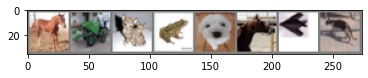

horse truck   cat  frog   dog horse plane   cat


In [11]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Try different pooling

### StochasticPool:

In [11]:
import torch
import torch.nn as nn

class StochasticPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(StochasticPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride or kernel_size
        self.padding = padding

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Calculate output dimensions
        out_h = (height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_w = (width + 2 * self.padding - self.kernel_size) // self.stride + 1
        # Add padding to input tensor
        x = nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))
        # Reshape tensor to size (batch_size * channels, 1, height, width)
        x_reshaped = x.view(batch_size * channels, 1, height, width)
        # Apply 2D max pooling with kernel_size and stride
        pool = nn.functional.max_pool2d(x_reshaped, self.kernel_size, self.stride)
        # Reshape tensor to size (batch_size, channels, out_h, out_w)
        pool_reshaped = pool.view(batch_size, channels, out_h, out_w)
        # Create mask tensor with same size as output tensor
        mask = torch.zeros_like(pool_reshaped)
        # Generate random mask with same size as output tensor
        rand_mask = torch.rand_like(pool_reshaped)
        # Assign mask values based on random values
        mask[rand_mask <= 0.5] = 1
        # Multiply output tensor by mask
        pool_reshaped *= mask

        return pool_reshaped

[epoch: 0, i:  4999] avg mini-batch loss: 2.111
[epoch: 0, i:  9999] avg mini-batch loss: 1.777
[epoch: 1, i:  4999] avg mini-batch loss: 1.531
[epoch: 1, i:  9999] avg mini-batch loss: 1.448
[epoch: 2, i:  4999] avg mini-batch loss: 1.360
[epoch: 2, i:  9999] avg mini-batch loss: 1.329
[epoch: 3, i:  4999] avg mini-batch loss: 1.268
[epoch: 3, i:  9999] avg mini-batch loss: 1.267
[epoch: 4, i:  4999] avg mini-batch loss: 1.226
[epoch: 4, i:  9999] avg mini-batch loss: 1.210
[epoch: 5, i:  4999] avg mini-batch loss: 1.182
[epoch: 5, i:  9999] avg mini-batch loss: 1.188
[epoch: 6, i:  4999] avg mini-batch loss: 1.150
[epoch: 6, i:  9999] avg mini-batch loss: 1.156
[epoch: 7, i:  4999] avg mini-batch loss: 1.133
[epoch: 7, i:  9999] avg mini-batch loss: 1.134
[epoch: 8, i:  4999] avg mini-batch loss: 1.110
[epoch: 8, i:  9999] avg mini-batch loss: 1.114
[epoch: 9, i:  4999] avg mini-batch loss: 1.092
[epoch: 9, i:  9999] avg mini-batch loss: 1.105
Finished Training.
9.548880302906037


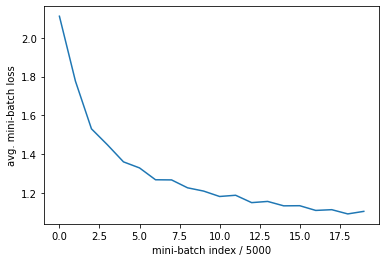

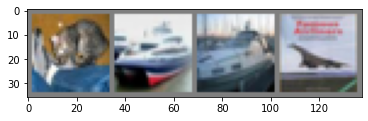

GroundTruth:    cat  ship  ship plane
Predicted:   ship   car  ship plane
Accuracy of the network on the 10000 test images: 59 %
Accuracy of plane : 62 %
Accuracy of   car : 73 %
Accuracy of  bird : 49 %
Accuracy of   cat : 37 %
Accuracy of  deer : 52 %
Accuracy of   dog : 47 %
Accuracy of  frog : 67 %
Accuracy of horse : 70 %
Accuracy of  ship : 74 %
Accuracy of truck : 63 %


In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #block one
        self.c_1 = nn.Conv2d(3, 10, 3, stride=1, padding=1)
        self.r_1 = nn.LeakyReLU(negative_slope=0.15)
        self.avg_1 = StochasticPool2d(2)

        #block two
        self.c_2 = nn.Conv2d(10, 20, 3, stride=1, padding=1)
        self.r_2 = nn.LeakyReLU(negative_slope=0.15)
        self.avg_2 = StochasticPool2d(2)

        self.l_1 = nn.Linear(1280, 100)
        self.r_3 = nn.LeakyReLU(negative_slope=0.15)
        self.l_2 = nn.Linear(100, 10)

    def forward(self, x):
        ###### Fill the blank here ######

        x = self.c_1(x)
        x = self.r_1(x)
        x = self.avg_1(x)
        x = self.c_2(x)
        x = self.r_2(x)
        x = self.avg_2(x)
        x = x.view(x.size(0), -1)
        x = self.l_1(x)
        x = self.r_3(x)
        x = self.l_2(x)

        return x

LeakyReLU(negative_slope=0.1), accuracy=0.64
<br>
LeakyReLU(negative_slope=0.2), accuracy=0.65
<br>
LeakyReLU(negative_slope=0.3), accuracy=0.62
<br>
LeakyReLU(negative_slope=0.15), accuracy=0.66
<br>
LeakyReLU(negative_slope=0.17), accuracy=0.66
<br>
LeakyReLU(negative_slope=0.12), accuracy=0.64
<br>
LeakyReLU(negative_slope=0.18), accuracy=0.64
<br>
LeakyReLU(negative_slope=0.05), accuracy=0.65
<br>
ELU(alpha=1), accuracy=64%
<br>
ELU(alpha=0.8), accuracy=63%
<br> 
PReLU(), acurracy=0.64%
<br>
SiLU(), accuracy=0.65%
<br>
Mish(), accuracy=0.65%
<br>
GELU(), accuracy=0.64%
<br>
LeakyReLU(negative_slope=0.15), maxpooling2d, accuracy=0.67
<br>
LeakyReLU(negative_slope=0.15), LPPool2d, accuracy=0.66

### MaxPool:

[epoch: 0, i:  4999] avg mini-batch loss: 1.770
[epoch: 0, i:  9999] avg mini-batch loss: 1.354
[epoch: 1, i:  4999] avg mini-batch loss: 1.134
[epoch: 1, i:  9999] avg mini-batch loss: 1.080
[epoch: 2, i:  4999] avg mini-batch loss: 0.952
[epoch: 2, i:  9999] avg mini-batch loss: 0.950
[epoch: 3, i:  4999] avg mini-batch loss: 0.838
[epoch: 3, i:  9999] avg mini-batch loss: 0.856
[epoch: 4, i:  4999] avg mini-batch loss: 0.749
[epoch: 4, i:  9999] avg mini-batch loss: 0.779
[epoch: 5, i:  4999] avg mini-batch loss: 0.670
[epoch: 5, i:  9999] avg mini-batch loss: 0.728
[epoch: 6, i:  4999] avg mini-batch loss: 0.616
[epoch: 6, i:  9999] avg mini-batch loss: 0.661
[epoch: 7, i:  4999] avg mini-batch loss: 0.569
[epoch: 7, i:  9999] avg mini-batch loss: 0.606
[epoch: 8, i:  4999] avg mini-batch loss: 0.511
[epoch: 8, i:  9999] avg mini-batch loss: 0.570
[epoch: 9, i:  4999] avg mini-batch loss: 0.461
[epoch: 9, i:  9999] avg mini-batch loss: 0.534
Finished Training.
7.886383752028148


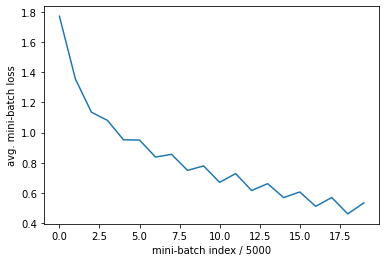

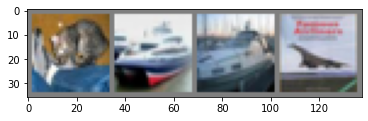

GroundTruth:    cat  ship  ship plane
Predicted:    dog   car plane plane
Accuracy of the network on the 10000 test images: 67 %
Accuracy of plane : 72 %
Accuracy of   car : 75 %
Accuracy of  bird : 50 %
Accuracy of   cat : 43 %
Accuracy of  deer : 60 %
Accuracy of   dog : 59 %
Accuracy of  frog : 77 %
Accuracy of horse : 79 %
Accuracy of  ship : 74 %
Accuracy of truck : 79 %


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #block one
        self.c_1 = nn.Conv2d(3, 10, 3, stride=1, padding=1)
        self.r_1 = nn.LeakyReLU(negative_slope=0.15)
        self.avg_1 = MaxPool2d(2)

        #block two
        self.c_2 = nn.Conv2d(10, 20, 3, stride=1, padding=1)
        self.r_2 = nn.LeakyReLU(negative_slope=0.15)
        self.avg_2 = MaxPool2d(2)

        self.l_1 = nn.Linear(1280, 100)
        self.r_3 = nn.LeakyReLU(negative_slope=0.15)
        self.l_2 = nn.Linear(100, 10)

    def forward(self, x):
        ###### Fill the blank here ######

        x = self.c_1(x)
        x = self.r_1(x)
        x = self.avg_1(x)
        x = self.c_2(x)
        x = self.r_2(x)
        x = self.avg_2(x)
        x = x.view(x.size(0), -1)
        x = self.l_1(x)
        x = self.r_3(x)
        x = self.l_2(x)

        return x

### AveragePool:

[epoch: 0, i:  4999] avg mini-batch loss: 1.856
[epoch: 0, i:  9999] avg mini-batch loss: 1.564
[epoch: 1, i:  4999] avg mini-batch loss: 1.381
[epoch: 1, i:  9999] avg mini-batch loss: 1.299
[epoch: 2, i:  4999] avg mini-batch loss: 1.181
[epoch: 2, i:  9999] avg mini-batch loss: 1.144
[epoch: 3, i:  4999] avg mini-batch loss: 1.055
[epoch: 3, i:  9999] avg mini-batch loss: 1.035
[epoch: 4, i:  4999] avg mini-batch loss: 0.946
[epoch: 4, i:  9999] avg mini-batch loss: 0.960
[epoch: 5, i:  4999] avg mini-batch loss: 0.858
[epoch: 5, i:  9999] avg mini-batch loss: 0.883
[epoch: 6, i:  4999] avg mini-batch loss: 0.796
[epoch: 6, i:  9999] avg mini-batch loss: 0.820
[epoch: 7, i:  4999] avg mini-batch loss: 0.729
[epoch: 7, i:  9999] avg mini-batch loss: 0.776
[epoch: 8, i:  4999] avg mini-batch loss: 0.677
[epoch: 8, i:  9999] avg mini-batch loss: 0.712
[epoch: 9, i:  4999] avg mini-batch loss: 0.617
[epoch: 9, i:  9999] avg mini-batch loss: 0.676
Finished Training.
7.738466195265452


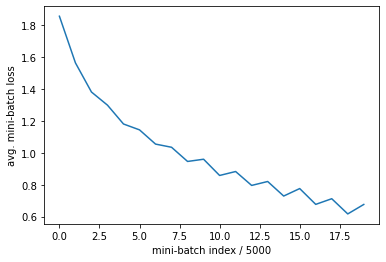

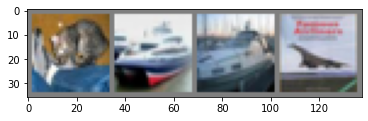

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 74 %
Accuracy of   car : 75 %
Accuracy of  bird : 61 %
Accuracy of   cat : 42 %
Accuracy of  deer : 60 %
Accuracy of   dog : 57 %
Accuracy of  frog : 71 %
Accuracy of horse : 71 %
Accuracy of  ship : 73 %
Accuracy of truck : 70 %


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #block one
        self.c_1 = nn.Conv2d(3, 10, 3, stride=1, padding=1)
        self.r_1 = nn.LeakyReLU(negative_slope=0.15)
        self.avg_1 = AvgPool2d(2)

        #block two
        self.c_2 = nn.Conv2d(10, 20, 3, stride=1, padding=1)
        self.r_2 = nn.LeakyReLU(negative_slope=0.15)
        self.avg_2 = AvgPool2d(2)

        self.l_1 = nn.Linear(1280, 100)
        self.r_3 = nn.LeakyReLU(negative_slope=0.15)
        self.l_2 = nn.Linear(100, 10)

    def forward(self, x):
        ###### Fill the blank here ######

        x = self.c_1(x)
        x = self.r_1(x)
        x = self.avg_1(x)
        x = self.c_2(x)
        x = self.r_2(x)
        x = self.avg_2(x)
        x = x.view(x.size(0), -1)
        x = self.l_1(x)
        x = self.r_3(x)
        x = self.l_2(x)

        return x

### LPPool:

[epoch: 0, i:  4999] avg mini-batch loss: 1.731
[epoch: 0, i:  9999] avg mini-batch loss: 1.437
[epoch: 1, i:  4999] avg mini-batch loss: 1.263
[epoch: 1, i:  9999] avg mini-batch loss: 1.194
[epoch: 2, i:  4999] avg mini-batch loss: 1.071
[epoch: 2, i:  9999] avg mini-batch loss: 1.043
[epoch: 3, i:  4999] avg mini-batch loss: 0.961
[epoch: 3, i:  9999] avg mini-batch loss: 0.960
[epoch: 4, i:  4999] avg mini-batch loss: 0.890
[epoch: 4, i:  9999] avg mini-batch loss: 0.905
[epoch: 5, i:  4999] avg mini-batch loss: 0.839
[epoch: 5, i:  9999] avg mini-batch loss: 0.853
[epoch: 6, i:  4999] avg mini-batch loss: 0.788
[epoch: 6, i:  9999] avg mini-batch loss: 0.821
[epoch: 7, i:  4999] avg mini-batch loss: 0.733
[epoch: 7, i:  9999] avg mini-batch loss: 0.784
[epoch: 8, i:  4999] avg mini-batch loss: 0.726
[epoch: 8, i:  9999] avg mini-batch loss: 0.739
[epoch: 9, i:  4999] avg mini-batch loss: 0.683
[epoch: 9, i:  9999] avg mini-batch loss: 0.725
Finished Training.
9.916852935155232


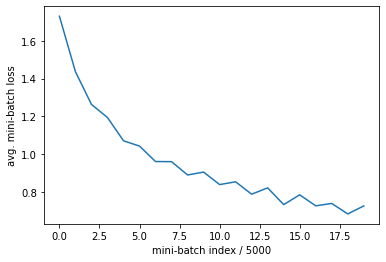

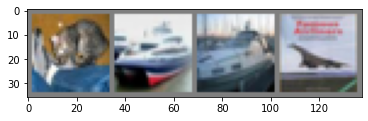

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane
Accuracy of the network on the 10000 test images: 67 %
Accuracy of plane : 81 %
Accuracy of   car : 80 %
Accuracy of  bird : 56 %
Accuracy of   cat : 34 %
Accuracy of  deer : 82 %
Accuracy of   dog : 63 %
Accuracy of  frog : 77 %
Accuracy of horse : 61 %
Accuracy of  ship : 71 %
Accuracy of truck : 66 %


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #block one
        self.c_1 = nn.Conv2d(3, 10, 3, stride=1, padding=1)
        self.r_1 = nn.LeakyReLU(negative_slope=0.15)
        self.avg_1 = LPPool2d(2, 2)

        #block two
        self.c_2 = nn.Conv2d(10, 20, 3, stride=1, padding=1)
        self.r_2 = nn.LeakyReLU(negative_slope=0.15)
        self.avg_2 = LPPool2d(2, 2)

        self.l_1 = nn.Linear(1280, 100)
        self.r_3 = nn.LeakyReLU(negative_slope=0.15)
        self.l_2 = nn.Linear(100, 10)

    def forward(self, x):
        ###### Fill the blank here ######
        x = self.c_1(x)
        x = self.r_1(x)
        x = self.avg_1(x)
        x = self.c_2(x)
        x = self.r_2(x)
        x = self.avg_2(x)
        x = x.view(x.size(0), -1)
        x = self.l_1(x)
        x = self.r_3(x)
        x = self.l_2(x)

        return x

## Try add some layers:

### Add up to 3 layers:

[epoch: 0, i:  4999] avg mini-batch loss: 2.098
[epoch: 0, i:  9999] avg mini-batch loss: 1.721
[epoch: 1, i:  4999] avg mini-batch loss: 1.453
[epoch: 1, i:  9999] avg mini-batch loss: 1.358
[epoch: 2, i:  4999] avg mini-batch loss: 1.243
[epoch: 2, i:  9999] avg mini-batch loss: 1.198
[epoch: 3, i:  4999] avg mini-batch loss: 1.113
[epoch: 3, i:  9999] avg mini-batch loss: 1.087
[epoch: 4, i:  4999] avg mini-batch loss: 1.016
[epoch: 4, i:  9999] avg mini-batch loss: 0.998
[epoch: 5, i:  4999] avg mini-batch loss: 0.938
[epoch: 5, i:  9999] avg mini-batch loss: 0.941
[epoch: 6, i:  4999] avg mini-batch loss: 0.867
[epoch: 6, i:  9999] avg mini-batch loss: 0.878
[epoch: 7, i:  4999] avg mini-batch loss: 0.807
[epoch: 7, i:  9999] avg mini-batch loss: 0.835
[epoch: 8, i:  4999] avg mini-batch loss: 0.772
[epoch: 8, i:  9999] avg mini-batch loss: 0.780
[epoch: 9, i:  4999] avg mini-batch loss: 0.729
[epoch: 9, i:  9999] avg mini-batch loss: 0.743
Finished Training.
9.521479801336925


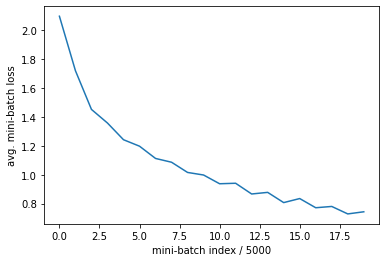

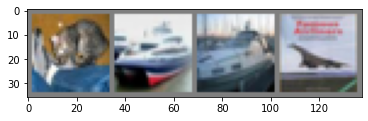

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship  ship plane
Accuracy of the network on the 10000 test images: 68 %
Accuracy of plane : 75 %
Accuracy of   car : 86 %
Accuracy of  bird : 58 %
Accuracy of   cat : 44 %
Accuracy of  deer : 57 %
Accuracy of   dog : 59 %
Accuracy of  frog : 74 %
Accuracy of horse : 71 %
Accuracy of  ship : 82 %
Accuracy of truck : 72 %


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(30*4*4, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        #Block one 
        x = self.pool(F.relu(self.conv1(x)))
        #Block two
        x = self.pool(F.relu(self.conv2(x)))
        #Block three
        x = self.pool(F.relu(self.conv3(x)))
        #Linear layer and activation layer at the end
        x = x.view(-1, 30*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Add up to three layers, normalize:

[epoch: 0, i:  4999] avg mini-batch loss: 1.682
[epoch: 0, i:  9999] avg mini-batch loss: 1.375
[epoch: 1, i:  4999] avg mini-batch loss: 1.152
[epoch: 1, i:  9999] avg mini-batch loss: 1.092
[epoch: 2, i:  4999] avg mini-batch loss: 0.982
[epoch: 2, i:  9999] avg mini-batch loss: 0.958
[epoch: 3, i:  4999] avg mini-batch loss: 0.883
[epoch: 3, i:  9999] avg mini-batch loss: 0.865
[epoch: 4, i:  4999] avg mini-batch loss: 0.817
[epoch: 4, i:  9999] avg mini-batch loss: 0.807
[epoch: 5, i:  4999] avg mini-batch loss: 0.759
[epoch: 5, i:  9999] avg mini-batch loss: 0.756
[epoch: 6, i:  4999] avg mini-batch loss: 0.707
[epoch: 6, i:  9999] avg mini-batch loss: 0.729
[epoch: 7, i:  4999] avg mini-batch loss: 0.667
[epoch: 7, i:  9999] avg mini-batch loss: 0.695
[epoch: 8, i:  4999] avg mini-batch loss: 0.635
[epoch: 8, i:  9999] avg mini-batch loss: 0.651
[epoch: 9, i:  4999] avg mini-batch loss: 0.611
[epoch: 9, i:  9999] avg mini-batch loss: 0.626
Finished Training.
10.468461708227794


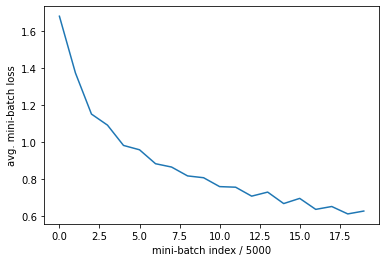

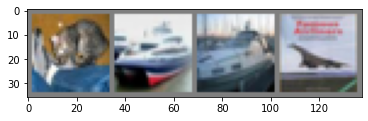

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship  ship plane
Accuracy of the network on the 10000 test images: 72 %
Accuracy of plane : 79 %
Accuracy of   car : 89 %
Accuracy of  bird : 59 %
Accuracy of   cat : 56 %
Accuracy of  deer : 73 %
Accuracy of   dog : 54 %
Accuracy of  frog : 73 %
Accuracy of horse : 80 %
Accuracy of  ship : 80 %
Accuracy of truck : 80 %


In [77]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(30*4*4, 100)
        self.fc2 = nn.Linear(100, 10)
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)
        self.bn3 = nn.BatchNorm2d(30)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 30*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Add up to 4 layers:

[epoch: 0, i:  4999] avg mini-batch loss: 2.282
[epoch: 0, i:  9999] avg mini-batch loss: 1.968
[epoch: 1, i:  4999] avg mini-batch loss: 1.697
[epoch: 1, i:  9999] avg mini-batch loss: 1.580
[epoch: 2, i:  4999] avg mini-batch loss: 1.457
[epoch: 2, i:  9999] avg mini-batch loss: 1.399
[epoch: 3, i:  4999] avg mini-batch loss: 1.316
[epoch: 3, i:  9999] avg mini-batch loss: 1.281
[epoch: 4, i:  4999] avg mini-batch loss: 1.206
[epoch: 4, i:  9999] avg mini-batch loss: 1.190
[epoch: 5, i:  4999] avg mini-batch loss: 1.131
[epoch: 5, i:  9999] avg mini-batch loss: 1.113
[epoch: 6, i:  4999] avg mini-batch loss: 1.068
[epoch: 6, i:  9999] avg mini-batch loss: 1.047
[epoch: 7, i:  4999] avg mini-batch loss: 1.003
[epoch: 7, i:  9999] avg mini-batch loss: 0.996
[epoch: 8, i:  4999] avg mini-batch loss: 0.954
[epoch: 8, i:  9999] avg mini-batch loss: 0.947
[epoch: 9, i:  4999] avg mini-batch loss: 0.900
[epoch: 9, i:  9999] avg mini-batch loss: 0.920
Finished Training.
10.89376556078593


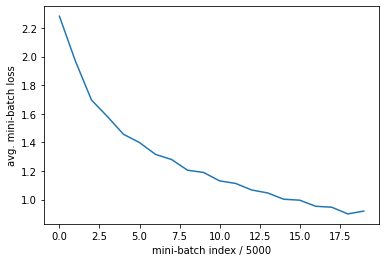

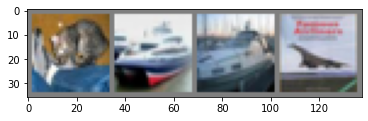

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 62 %
Accuracy of plane : 68 %
Accuracy of   car : 61 %
Accuracy of  bird : 42 %
Accuracy of   cat : 62 %
Accuracy of  deer : 57 %
Accuracy of   dog : 44 %
Accuracy of  frog : 57 %
Accuracy of horse : 75 %
Accuracy of  ship : 75 %
Accuracy of truck : 79 %


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=30, out_channels=40, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(40*2*2, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        #Block one
        x = self.pool(F.relu(self.conv1(x)))
        #Block two
        x = self.pool(F.relu(self.conv2(x)))
        #Block three
        x = self.pool(F.relu(self.conv3(x)))
        #Block four
        x = self.pool(F.relu(self.conv4(x)))
        #Linear layer and activation layer at the end
        x = x.view(-1, 40*2*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 4 layers with only dropout, p=0.2:

[epoch: 0, i:  4999] avg mini-batch loss: 2.302
[epoch: 0, i:  9999] avg mini-batch loss: 2.085
[epoch: 1, i:  4999] avg mini-batch loss: 1.766
[epoch: 1, i:  9999] avg mini-batch loss: 1.660
[epoch: 2, i:  4999] avg mini-batch loss: 1.509
[epoch: 2, i:  9999] avg mini-batch loss: 1.454
[epoch: 3, i:  4999] avg mini-batch loss: 1.364
[epoch: 3, i:  9999] avg mini-batch loss: 1.336
[epoch: 4, i:  4999] avg mini-batch loss: 1.262
[epoch: 4, i:  9999] avg mini-batch loss: 1.220
[epoch: 5, i:  4999] avg mini-batch loss: 1.165
[epoch: 5, i:  9999] avg mini-batch loss: 1.147
[epoch: 6, i:  4999] avg mini-batch loss: 1.096
[epoch: 6, i:  9999] avg mini-batch loss: 1.090
[epoch: 7, i:  4999] avg mini-batch loss: 1.029
[epoch: 7, i:  9999] avg mini-batch loss: 1.039
[epoch: 8, i:  4999] avg mini-batch loss: 0.996
[epoch: 8, i:  9999] avg mini-batch loss: 0.989
[epoch: 9, i:  4999] avg mini-batch loss: 0.956
[epoch: 9, i:  9999] avg mini-batch loss: 0.951
Finished Training.
11.144482668240865


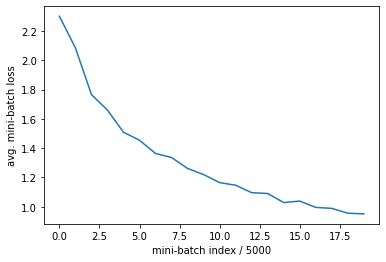

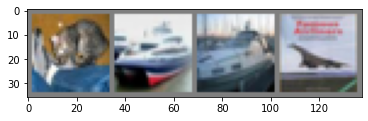

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship  ship plane
Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 68 %
Accuracy of   car : 79 %
Accuracy of  bird : 53 %
Accuracy of   cat : 49 %
Accuracy of  deer : 47 %
Accuracy of   dog : 52 %
Accuracy of  frog : 81 %
Accuracy of horse : 70 %
Accuracy of  ship : 79 %
Accuracy of truck : 72 %


In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=30, out_channels=40, kernel_size=3, padding=1)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(40*2*2, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):$
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #Dropout added here
        x = self.dropout(x)
        x = x.view(-1, 40*2*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 4 layers with dropout only, p=0.1:

[epoch: 0, i:  4999] avg mini-batch loss: 2.299
[epoch: 0, i:  9999] avg mini-batch loss: 1.996
[epoch: 1, i:  4999] avg mini-batch loss: 1.690
[epoch: 1, i:  9999] avg mini-batch loss: 1.582
[epoch: 2, i:  4999] avg mini-batch loss: 1.472
[epoch: 2, i:  9999] avg mini-batch loss: 1.425
[epoch: 3, i:  4999] avg mini-batch loss: 1.355
[epoch: 3, i:  9999] avg mini-batch loss: 1.319
[epoch: 4, i:  4999] avg mini-batch loss: 1.255
[epoch: 4, i:  9999] avg mini-batch loss: 1.231
[epoch: 5, i:  4999] avg mini-batch loss: 1.173
[epoch: 5, i:  9999] avg mini-batch loss: 1.172
[epoch: 6, i:  4999] avg mini-batch loss: 1.115
[epoch: 6, i:  9999] avg mini-batch loss: 1.095
[epoch: 7, i:  4999] avg mini-batch loss: 1.037
[epoch: 7, i:  9999] avg mini-batch loss: 1.045
[epoch: 8, i:  4999] avg mini-batch loss: 0.996
[epoch: 8, i:  9999] avg mini-batch loss: 0.985
[epoch: 9, i:  4999] avg mini-batch loss: 0.944
[epoch: 9, i:  9999] avg mini-batch loss: 0.950
Finished Training.
11.13000266154607


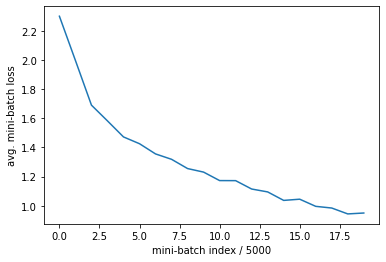

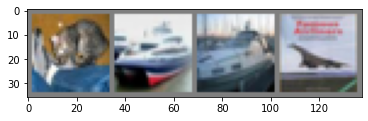

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 72 %
Accuracy of   car : 75 %
Accuracy of  bird : 54 %
Accuracy of   cat : 39 %
Accuracy of  deer : 42 %
Accuracy of   dog : 66 %
Accuracy of  frog : 72 %
Accuracy of horse : 73 %
Accuracy of  ship : 80 %
Accuracy of truck : 74 %


In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=30, out_channels=40, kernel_size=3, padding=1)
        self.dropout = nn.Dropout2d(p=0.1)
        self.fc1 = nn.Linear(40*2*2, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        ###### Fill the blank here ######

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 40*2*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 4 layers with dropout, normalize each layer:

[epoch: 0, i:  4999] avg mini-batch loss: 1.768
[epoch: 0, i:  9999] avg mini-batch loss: 1.441
[epoch: 1, i:  4999] avg mini-batch loss: 1.224
[epoch: 1, i:  9999] avg mini-batch loss: 1.157
[epoch: 2, i:  4999] avg mini-batch loss: 1.075
[epoch: 2, i:  9999] avg mini-batch loss: 1.044
[epoch: 3, i:  4999] avg mini-batch loss: 0.992
[epoch: 3, i:  9999] avg mini-batch loss: 0.978
[epoch: 4, i:  4999] avg mini-batch loss: 0.938
[epoch: 4, i:  9999] avg mini-batch loss: 0.921
[epoch: 5, i:  4999] avg mini-batch loss: 0.894
[epoch: 5, i:  9999] avg mini-batch loss: 0.891
[epoch: 6, i:  4999] avg mini-batch loss: 0.855
[epoch: 6, i:  9999] avg mini-batch loss: 0.863
[epoch: 7, i:  4999] avg mini-batch loss: 0.824
[epoch: 7, i:  9999] avg mini-batch loss: 0.836
[epoch: 8, i:  4999] avg mini-batch loss: 0.803
[epoch: 8, i:  9999] avg mini-batch loss: 0.819
[epoch: 9, i:  4999] avg mini-batch loss: 0.777
[epoch: 9, i:  9999] avg mini-batch loss: 0.800
Finished Training.
12.74227872689565


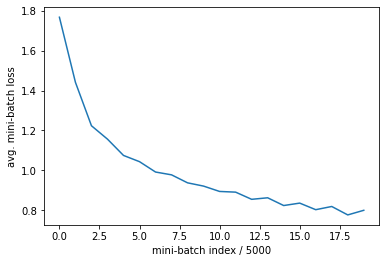

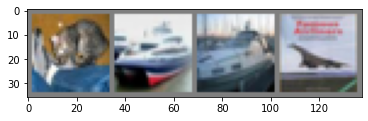

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship truck  ship
Accuracy of the network on the 10000 test images: 70 %
Accuracy of plane : 71 %
Accuracy of   car : 86 %
Accuracy of  bird : 56 %
Accuracy of   cat : 51 %
Accuracy of  deer : 62 %
Accuracy of   dog : 62 %
Accuracy of  frog : 82 %
Accuracy of horse : 67 %
Accuracy of  ship : 83 %
Accuracy of truck : 76 %


In [76]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=30, out_channels=40, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)
        self.bn3 = nn.BatchNorm2d(30)
        self.bn4 = nn.BatchNorm2d(40)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(40*2*2, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        ###### Fill the blank here ######

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 40*2*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 4 layers without dropout, normalize each layer:

[epoch: 0, i:  4999] avg mini-batch loss: 1.737
[epoch: 0, i:  9999] avg mini-batch loss: 1.379
[epoch: 1, i:  4999] avg mini-batch loss: 1.164
[epoch: 1, i:  9999] avg mini-batch loss: 1.100
[epoch: 2, i:  4999] avg mini-batch loss: 0.992
[epoch: 2, i:  9999] avg mini-batch loss: 0.984
[epoch: 3, i:  4999] avg mini-batch loss: 0.915
[epoch: 3, i:  9999] avg mini-batch loss: 0.891
[epoch: 4, i:  4999] avg mini-batch loss: 0.840
[epoch: 4, i:  9999] avg mini-batch loss: 0.843
[epoch: 5, i:  4999] avg mini-batch loss: 0.802
[epoch: 5, i:  9999] avg mini-batch loss: 0.818
[epoch: 6, i:  4999] avg mini-batch loss: 0.769
[epoch: 6, i:  9999] avg mini-batch loss: 0.781
[epoch: 7, i:  4999] avg mini-batch loss: 0.726
[epoch: 7, i:  9999] avg mini-batch loss: 0.746
[epoch: 8, i:  4999] avg mini-batch loss: 0.727
[epoch: 8, i:  9999] avg mini-batch loss: 0.717
[epoch: 9, i:  4999] avg mini-batch loss: 0.693
[epoch: 9, i:  9999] avg mini-batch loss: 0.704
Finished Training.
12.37363129456838


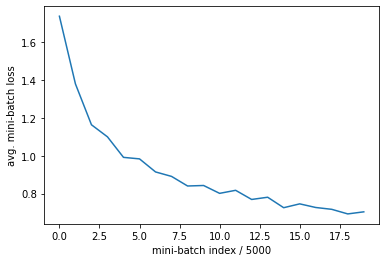

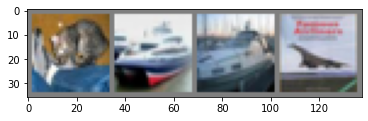

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car   car plane
Accuracy of the network on the 10000 test images: 71 %
Accuracy of plane : 83 %
Accuracy of   car : 85 %
Accuracy of  bird : 62 %
Accuracy of   cat : 62 %
Accuracy of  deer : 71 %
Accuracy of   dog : 51 %
Accuracy of  frog : 74 %
Accuracy of horse : 74 %
Accuracy of  ship : 74 %
Accuracy of truck : 75 %


In [75]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=30, out_channels=40, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)
        self.bn3 = nn.BatchNorm2d(30)
        self.bn4 = nn.BatchNorm2d(40)
        self.fc1 = nn.Linear(40*2*2, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 40*2*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Add up to 5 layers, normalize each layer:

[epoch: 0, i:  4999] avg mini-batch loss: 1.912
[epoch: 0, i:  9999] avg mini-batch loss: 1.631
[epoch: 1, i:  4999] avg mini-batch loss: 1.414
[epoch: 1, i:  9999] avg mini-batch loss: 1.334
[epoch: 2, i:  4999] avg mini-batch loss: 1.223
[epoch: 2, i:  9999] avg mini-batch loss: 1.194
[epoch: 3, i:  4999] avg mini-batch loss: 1.117
[epoch: 3, i:  9999] avg mini-batch loss: 1.085
[epoch: 4, i:  4999] avg mini-batch loss: 1.048
[epoch: 4, i:  9999] avg mini-batch loss: 1.017
[epoch: 5, i:  4999] avg mini-batch loss: 0.980
[epoch: 5, i:  9999] avg mini-batch loss: 0.978
[epoch: 6, i:  4999] avg mini-batch loss: 0.927
[epoch: 6, i:  9999] avg mini-batch loss: 0.933
[epoch: 7, i:  4999] avg mini-batch loss: 0.892
[epoch: 7, i:  9999] avg mini-batch loss: 0.904
[epoch: 8, i:  4999] avg mini-batch loss: 0.862
[epoch: 8, i:  9999] avg mini-batch loss: 0.869
[epoch: 9, i:  4999] avg mini-batch loss: 0.837
[epoch: 9, i:  9999] avg mini-batch loss: 0.841
Finished Training.
13.89130485455195


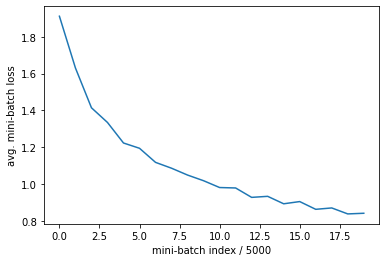

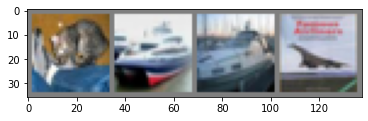

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship   cat plane
Accuracy of the network on the 10000 test images: 68 %
Accuracy of plane : 79 %
Accuracy of   car : 80 %
Accuracy of  bird : 47 %
Accuracy of   cat : 41 %
Accuracy of  deer : 62 %
Accuracy of   dog : 70 %
Accuracy of  frog : 78 %
Accuracy of horse : 73 %
Accuracy of  ship : 77 %
Accuracy of truck : 77 %


In [74]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=30, out_channels=40, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=40, out_channels=50, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)
        self.bn3 = nn.BatchNorm2d(30)
        self.bn4 = nn.BatchNorm2d(40)
        self.bn5 = nn.BatchNorm2d(50)
        self.fc1 = nn.Linear(50*1*1, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = x.view(-1, 50*1*1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### increase channel size:

[epoch: 0, i:  4999] avg mini-batch loss: 1.811
[epoch: 0, i:  9999] avg mini-batch loss: 1.486
[epoch: 1, i:  4999] avg mini-batch loss: 1.261
[epoch: 1, i:  9999] avg mini-batch loss: 1.163
[epoch: 2, i:  4999] avg mini-batch loss: 1.049
[epoch: 2, i:  9999] avg mini-batch loss: 0.998
[epoch: 3, i:  4999] avg mini-batch loss: 0.912
[epoch: 3, i:  9999] avg mini-batch loss: 0.904
[epoch: 4, i:  4999] avg mini-batch loss: 0.834
[epoch: 4, i:  9999] avg mini-batch loss: 0.845
[epoch: 5, i:  4999] avg mini-batch loss: 0.777
[epoch: 5, i:  9999] avg mini-batch loss: 0.780
[epoch: 6, i:  4999] avg mini-batch loss: 0.723
[epoch: 6, i:  9999] avg mini-batch loss: 0.733
[epoch: 7, i:  4999] avg mini-batch loss: 0.674
[epoch: 7, i:  9999] avg mini-batch loss: 0.686
[epoch: 8, i:  4999] avg mini-batch loss: 0.641
[epoch: 8, i:  9999] avg mini-batch loss: 0.644
[epoch: 9, i:  4999] avg mini-batch loss: 0.600
[epoch: 9, i:  9999] avg mini-batch loss: 0.611
Finished Training.
14.117513557275137


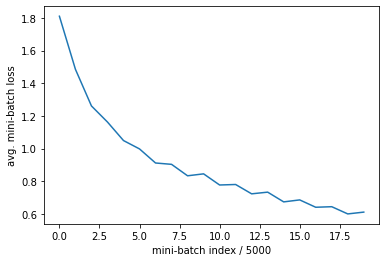

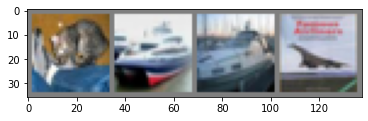

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship plane plane
Accuracy of the network on the 10000 test images: 72 %
Accuracy of plane : 79 %
Accuracy of   car : 84 %
Accuracy of  bird : 64 %
Accuracy of   cat : 44 %
Accuracy of  deer : 65 %
Accuracy of   dog : 66 %
Accuracy of  frog : 67 %
Accuracy of horse : 87 %
Accuracy of  ship : 81 %
Accuracy of truck : 84 %


In [73]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=30, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=30, out_channels=60, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=60, out_channels=120, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=120, out_channels=240, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(30)
        self.bn3 = nn.BatchNorm2d(60)
        self.bn4 = nn.BatchNorm2d(120)
        self.bn5 = nn.BatchNorm2d(240)
        #self.dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(240*1*1, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        ###### Fill the blank here ######

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        #x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 240*1*1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Try different learnin rate, batch size and epochs:

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


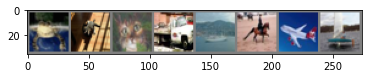

 frog   cat   cat truck  ship horse plane  ship


In [15]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=120, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=120, out_channels=240, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=240, out_channels=480, kernel_size=3, padding=1)
        self.af = nn.LeakyReLU(negative_slope=0.15)
        self.fc1 = nn.Linear(480*4*4, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 10)
        self.bn1 = nn.BatchNorm2d(120)
        self.bn2 = nn.BatchNorm2d(240)
        self.bn3 = nn.BatchNorm2d(480)

    def forward(self, x):
        ###### Fill the blank here ######

        x = self.pool(self.af(self.bn1(self.conv1(x))))
        x = self.pool(self.af(self.bn2(self.conv2(x))))
        x = self.pool(self.af(self.bn3(self.conv3(x))))
        #print(x.shape)
        x = x.view(-1, 480*4*4)
        x = self.af(self.fc1(x))
        x = self.af(self.fc2(x))
        x = self.fc3(x)
        return x

[epoch: 0, i:   999] avg mini-batch loss: 1.880
[epoch: 0, i:  1999] avg mini-batch loss: 1.480
[epoch: 0, i:  2999] avg mini-batch loss: 1.261
[epoch: 0, i:  3999] avg mini-batch loss: 1.183
[epoch: 0, i:  4999] avg mini-batch loss: 1.103
[epoch: 0, i:  5999] avg mini-batch loss: 1.034
[epoch: 1, i:   999] avg mini-batch loss: 0.934
[epoch: 1, i:  1999] avg mini-batch loss: 0.889
[epoch: 1, i:  2999] avg mini-batch loss: 0.875
[epoch: 1, i:  3999] avg mini-batch loss: 0.804
[epoch: 1, i:  4999] avg mini-batch loss: 0.816
[epoch: 1, i:  5999] avg mini-batch loss: 0.784
[epoch: 2, i:   999] avg mini-batch loss: 0.657
[epoch: 2, i:  1999] avg mini-batch loss: 0.687
[epoch: 2, i:  2999] avg mini-batch loss: 0.694
[epoch: 2, i:  3999] avg mini-batch loss: 0.660
[epoch: 2, i:  4999] avg mini-batch loss: 0.613
[epoch: 2, i:  5999] avg mini-batch loss: 0.631
[epoch: 3, i:   999] avg mini-batch loss: 0.516
[epoch: 3, i:  1999] avg mini-batch loss: 0.511
[epoch: 3, i:  2999] avg mini-batch loss

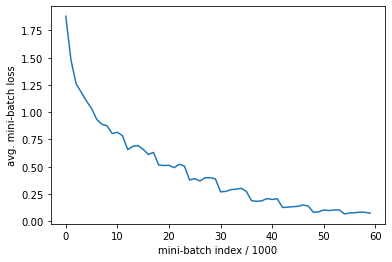

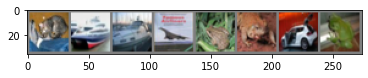

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 81 %
Accuracy of plane : 80 %
Accuracy of   car : 90 %
Accuracy of  bird : 78 %
Accuracy of   cat : 68 %
Accuracy of  deer : 78 %
Accuracy of   dog : 67 %
Accuracy of  frog : 81 %
Accuracy of horse : 83 %
Accuracy of  ship : 88 %
Accuracy of truck : 88 %


In [18]:
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()

# SGD
opt = optim.Adamax(net.parameters()) 

# Training procedure
st = time.time()
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
#         print(inputs)
#         print(labels)
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')
et = time.time()
print((et-st)/60)

plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()


# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

[epoch: 0, i:   999] avg mini-batch loss: 1.710
[epoch: 0, i:  1999] avg mini-batch loss: 1.410
[epoch: 0, i:  2999] avg mini-batch loss: 1.276
[epoch: 0, i:  3999] avg mini-batch loss: 1.182
[epoch: 0, i:  4999] avg mini-batch loss: 1.101
[epoch: 0, i:  5999] avg mini-batch loss: 1.049
[epoch: 1, i:   999] avg mini-batch loss: 0.967
[epoch: 1, i:  1999] avg mini-batch loss: 0.938
[epoch: 1, i:  2999] avg mini-batch loss: 0.888
[epoch: 1, i:  3999] avg mini-batch loss: 0.898
[epoch: 1, i:  4999] avg mini-batch loss: 0.863
[epoch: 1, i:  5999] avg mini-batch loss: 0.849
[epoch: 2, i:   999] avg mini-batch loss: 0.785
[epoch: 2, i:  1999] avg mini-batch loss: 0.754
[epoch: 2, i:  2999] avg mini-batch loss: 0.767
[epoch: 2, i:  3999] avg mini-batch loss: 0.764
[epoch: 2, i:  4999] avg mini-batch loss: 0.715
[epoch: 2, i:  5999] avg mini-batch loss: 0.728
[epoch: 3, i:   999] avg mini-batch loss: 0.661
[epoch: 3, i:  1999] avg mini-batch loss: 0.663
[epoch: 3, i:  2999] avg mini-batch loss

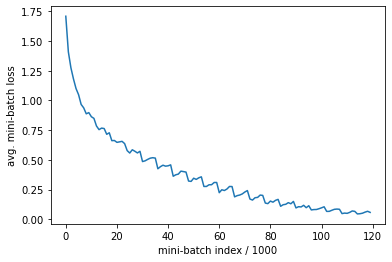

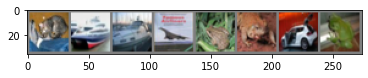

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 80 %
Accuracy of plane : 80 %
Accuracy of   car : 88 %
Accuracy of  bird : 68 %
Accuracy of   cat : 69 %
Accuracy of  deer : 74 %
Accuracy of   dog : 68 %
Accuracy of  frog : 86 %
Accuracy of horse : 90 %
Accuracy of  ship : 90 %
Accuracy of truck : 89 %


In [57]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=60, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=60, out_channels=120, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=120, out_channels=240, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(240*4*4, 100)
        self.fc2 = nn.Linear(100, 10)
        self.bn1 = nn.BatchNorm2d(60)
        self.bn2 = nn.BatchNorm2d(120)
        self.bn3 = nn.BatchNorm2d(240)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 240*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

[epoch: 0, i:   999] avg mini-batch loss: 1.689
[epoch: 0, i:  1999] avg mini-batch loss: 1.402
[epoch: 0, i:  2999] avg mini-batch loss: 1.298
[epoch: 0, i:  3999] avg mini-batch loss: 1.183
[epoch: 0, i:  4999] avg mini-batch loss: 1.100
[epoch: 0, i:  5999] avg mini-batch loss: 1.075
[epoch: 1, i:   999] avg mini-batch loss: 0.969
[epoch: 1, i:  1999] avg mini-batch loss: 0.948
[epoch: 1, i:  2999] avg mini-batch loss: 0.933
[epoch: 1, i:  3999] avg mini-batch loss: 0.898
[epoch: 1, i:  4999] avg mini-batch loss: 0.889
[epoch: 1, i:  5999] avg mini-batch loss: 0.849
[epoch: 2, i:   999] avg mini-batch loss: 0.788
[epoch: 2, i:  1999] avg mini-batch loss: 0.771
[epoch: 2, i:  2999] avg mini-batch loss: 0.776
[epoch: 2, i:  3999] avg mini-batch loss: 0.759
[epoch: 2, i:  4999] avg mini-batch loss: 0.757
[epoch: 2, i:  5999] avg mini-batch loss: 0.726
[epoch: 3, i:   999] avg mini-batch loss: 0.655
[epoch: 3, i:  1999] avg mini-batch loss: 0.649
[epoch: 3, i:  2999] avg mini-batch loss

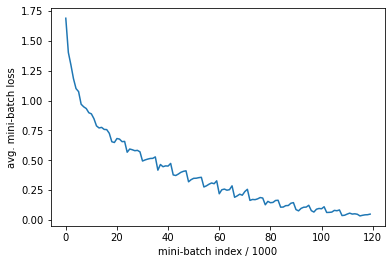

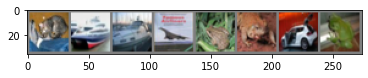

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 81 %
Accuracy of plane : 78 %
Accuracy of   car : 88 %
Accuracy of  bird : 67 %
Accuracy of   cat : 56 %
Accuracy of  deer : 79 %
Accuracy of   dog : 78 %
Accuracy of  frog : 87 %
Accuracy of horse : 91 %
Accuracy of  ship : 93 %
Accuracy of truck : 90 %


In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=120, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=120, out_channels=240, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=240, out_channels=480, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(480*4*4, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 10)
        self.bn1 = nn.BatchNorm2d(120)
        self.bn2 = nn.BatchNorm2d(240)
        self.bn3 = nn.BatchNorm2d(480)

    def forward(self, x):
        ###### Fill the blank here ######

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        #print(x.shape)
        x = x.view(-1, 480*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

[epoch: 0, i:   999] avg mini-batch loss: 1.673
[epoch: 0, i:  1999] avg mini-batch loss: 1.406
[epoch: 0, i:  2999] avg mini-batch loss: 1.282
[epoch: 0, i:  3999] avg mini-batch loss: 1.209
[epoch: 0, i:  4999] avg mini-batch loss: 1.144
[epoch: 0, i:  5999] avg mini-batch loss: 1.080
[epoch: 1, i:   999] avg mini-batch loss: 0.988
[epoch: 1, i:  1999] avg mini-batch loss: 0.928
[epoch: 1, i:  2999] avg mini-batch loss: 0.941
[epoch: 1, i:  3999] avg mini-batch loss: 0.929
[epoch: 1, i:  4999] avg mini-batch loss: 0.922
[epoch: 1, i:  5999] avg mini-batch loss: 0.884
[epoch: 2, i:   999] avg mini-batch loss: 0.807
[epoch: 2, i:  1999] avg mini-batch loss: 0.822
[epoch: 2, i:  2999] avg mini-batch loss: 0.798
[epoch: 2, i:  3999] avg mini-batch loss: 0.776
[epoch: 2, i:  4999] avg mini-batch loss: 0.754
[epoch: 2, i:  5999] avg mini-batch loss: 0.764
[epoch: 3, i:   999] avg mini-batch loss: 0.667
[epoch: 3, i:  1999] avg mini-batch loss: 0.685
[epoch: 3, i:  2999] avg mini-batch loss

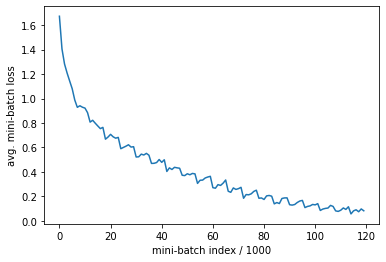

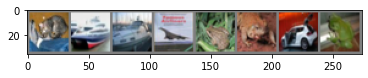

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 80 %
Accuracy of plane : 83 %
Accuracy of   car : 93 %
Accuracy of  bird : 71 %
Accuracy of   cat : 61 %
Accuracy of  deer : 80 %
Accuracy of   dog : 70 %
Accuracy of  frog : 87 %
Accuracy of horse : 81 %
Accuracy of  ship : 89 %
Accuracy of truck : 82 %


In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=240, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=240, out_channels=480, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=480, out_channels=960, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(960*4*4, 100)
        self.fc2 = nn.Linear(100, 10)
        self.bn1 = nn.BatchNorm2d(240)
        self.bn2 = nn.BatchNorm2d(480)
        self.bn3 = nn.BatchNorm2d(960)

    def forward(self, x):
        ###### Fill the blank here ######

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        #print(x.shape)
        x = x.view(-1, 960*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

[epoch: 0, i:   999] avg mini-batch loss: 1.752
[epoch: 0, i:  1999] avg mini-batch loss: 1.411
[epoch: 0, i:  2999] avg mini-batch loss: 1.274
[epoch: 0, i:  3999] avg mini-batch loss: 1.180
[epoch: 0, i:  4999] avg mini-batch loss: 1.112
[epoch: 0, i:  5999] avg mini-batch loss: 1.049
[epoch: 1, i:   999] avg mini-batch loss: 0.941
[epoch: 1, i:  1999] avg mini-batch loss: 0.934
[epoch: 1, i:  2999] avg mini-batch loss: 0.902
[epoch: 1, i:  3999] avg mini-batch loss: 0.875
[epoch: 1, i:  4999] avg mini-batch loss: 0.831
[epoch: 1, i:  5999] avg mini-batch loss: 0.826
[epoch: 2, i:   999] avg mini-batch loss: 0.737
[epoch: 2, i:  1999] avg mini-batch loss: 0.725
[epoch: 2, i:  2999] avg mini-batch loss: 0.711
[epoch: 2, i:  3999] avg mini-batch loss: 0.725
[epoch: 2, i:  4999] avg mini-batch loss: 0.713
[epoch: 2, i:  5999] avg mini-batch loss: 0.681
[epoch: 3, i:   999] avg mini-batch loss: 0.598
[epoch: 3, i:  1999] avg mini-batch loss: 0.605
[epoch: 3, i:  2999] avg mini-batch loss

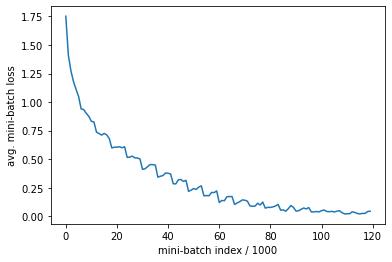

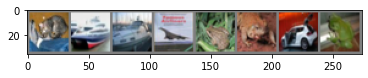

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship  ship  ship
Accuracy of the network on the 10000 test images: 81 %
Accuracy of plane : 84 %
Accuracy of   car : 87 %
Accuracy of  bird : 71 %
Accuracy of   cat : 56 %
Accuracy of  deer : 77 %
Accuracy of   dog : 79 %
Accuracy of  frog : 90 %
Accuracy of horse : 84 %
Accuracy of  ship : 90 %
Accuracy of truck : 87 %


#### Following network implementations are from internet

### LeNet:

[epoch: 0, i:   999] avg mini-batch loss: 2.297
[epoch: 0, i:  1999] avg mini-batch loss: 2.143
[epoch: 0, i:  2999] avg mini-batch loss: 1.961
[epoch: 0, i:  3999] avg mini-batch loss: 1.808
[epoch: 0, i:  4999] avg mini-batch loss: 1.690
[epoch: 0, i:  5999] avg mini-batch loss: 1.605
[epoch: 1, i:   999] avg mini-batch loss: 1.544
[epoch: 1, i:  1999] avg mini-batch loss: 1.488
[epoch: 1, i:  2999] avg mini-batch loss: 1.456
[epoch: 1, i:  3999] avg mini-batch loss: 1.428
[epoch: 1, i:  4999] avg mini-batch loss: 1.428
[epoch: 1, i:  5999] avg mini-batch loss: 1.366
[epoch: 2, i:   999] avg mini-batch loss: 1.314
[epoch: 2, i:  1999] avg mini-batch loss: 1.312
[epoch: 2, i:  2999] avg mini-batch loss: 1.286
[epoch: 2, i:  3999] avg mini-batch loss: 1.256
[epoch: 2, i:  4999] avg mini-batch loss: 1.259
[epoch: 2, i:  5999] avg mini-batch loss: 1.255
[epoch: 3, i:   999] avg mini-batch loss: 1.191
[epoch: 3, i:  1999] avg mini-batch loss: 1.171
[epoch: 3, i:  2999] avg mini-batch loss

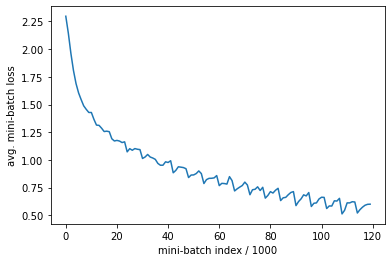

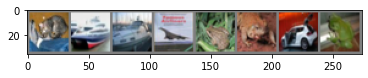

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane
Accuracy of the network on the 10000 test images: 61 %
Accuracy of plane : 67 %
Accuracy of   car : 73 %
Accuracy of  bird : 46 %
Accuracy of   cat : 47 %
Accuracy of  deer : 57 %
Accuracy of   dog : 55 %
Accuracy of  frog : 54 %
Accuracy of horse : 71 %
Accuracy of  ship : 70 %
Accuracy of truck : 68 %


In [89]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # define layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        # apply layers
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

### AlexNet:

In [43]:
transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


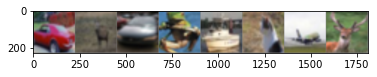

  car  deer   car  frog  ship   cat plane  deer
cuda:0


In [44]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


[epoch: 0, i:   999] avg mini-batch loss: 3.214
[epoch: 0, i:  1999] avg mini-batch loss: 2.091
[epoch: 0, i:  2999] avg mini-batch loss: 1.847
[epoch: 0, i:  3999] avg mini-batch loss: 1.712
[epoch: 0, i:  4999] avg mini-batch loss: 1.605
[epoch: 0, i:  5999] avg mini-batch loss: 1.501
[epoch: 1, i:   999] avg mini-batch loss: 1.435
[epoch: 1, i:  1999] avg mini-batch loss: 1.368
[epoch: 1, i:  2999] avg mini-batch loss: 1.306
[epoch: 1, i:  3999] avg mini-batch loss: 1.251
[epoch: 1, i:  4999] avg mini-batch loss: 1.184
[epoch: 1, i:  5999] avg mini-batch loss: 1.163
[epoch: 2, i:   999] avg mini-batch loss: 1.102
[epoch: 2, i:  1999] avg mini-batch loss: 1.035
[epoch: 2, i:  2999] avg mini-batch loss: 1.000
[epoch: 2, i:  3999] avg mini-batch loss: 0.988
[epoch: 2, i:  4999] avg mini-batch loss: 0.938
[epoch: 2, i:  5999] avg mini-batch loss: 0.927
[epoch: 3, i:   999] avg mini-batch loss: 0.850
[epoch: 3, i:  1999] avg mini-batch loss: 0.843
[epoch: 3, i:  2999] avg mini-batch loss

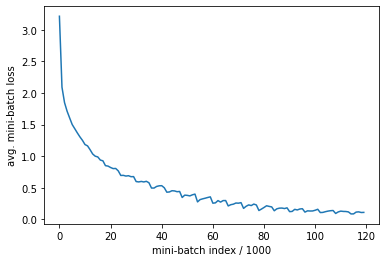

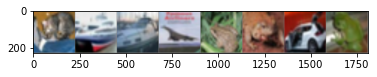

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car plane
Accuracy of the network on the 10000 test images: 81 %
Accuracy of plane : 82 %
Accuracy of   car : 88 %
Accuracy of  bird : 68 %
Accuracy of   cat : 69 %
Accuracy of  deer : 78 %
Accuracy of   dog : 77 %
Accuracy of  frog : 81 %
Accuracy of horse : 87 %
Accuracy of  ship : 88 %
Accuracy of truck : 84 %


In [109]:
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()

# SGD
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 


# Training procedure
st = time.time()
avg_losses = []   # Avg. losses.
epochs = 20       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
#         print(inputs)
#         print(labels)
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')
et = time.time()
print((et-st)/60)

plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()


# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

### VGG

In [1]:
class VGG(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


NameError: name 'nn' is not defined

In [ ]:
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()

# SGD
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 


# Training procedure
st = time.time()
avg_losses = []   # Avg. losses.
epochs = 20       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
#         print(inputs)
#         print(labels)
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')
et = time.time()
print((et-st)/60)

plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()


# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

batch_size=8, accuracy=73%
<br>
batch_size=16, accuracy=72%
<br>
batch_size=32, accuracy=71%
<br>
batch_size=8, epochs=20, accuracy=74%
<br>
batch_size=8, epochs=40, accuracy=72%
<br> 
batch_szie=16, epoches=40, accuraacy=74%
<br> 
batch_szie=8, epoches=20, accuraacy=80%
<br>
batch_szie=8, epoches=20, accuraacy=81%, keep increasing chnnel size


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


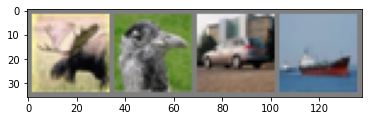

 deer  bird   car  ship


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


0.3
[epoch: 0, i:   999] avg mini-batch loss: 2.185
[epoch: 0, i:  1999] avg mini-batch loss: 1.887
[epoch: 0, i:  2999] avg mini-batch loss: 1.776
[epoch: 0, i:  3999] avg mini-batch loss: 1.698
[epoch: 0, i:  4999] avg mini-batch loss: 1.667
[epoch: 0, i:  5999] avg mini-batch loss: 1.644
[epoch: 0, i:  6999] avg mini-batch loss: 1.609
[epoch: 0, i:  7999] avg mini-batch loss: 1.583
[epoch: 0, i:  8999] avg mini-batch loss: 1.540
[epoch: 0, i:  9999] avg mini-batch loss: 1.526
[epoch: 0, i: 10999] avg mini-batch loss: 1.494
[epoch: 0, i: 11999] avg mini-batch loss: 1.460
[epoch: 1, i:   999] avg mini-batch loss: 1.440
[epoch: 1, i:  1999] avg mini-batch loss: 1.389
[epoch: 1, i:  2999] avg mini-batch loss: 1.386
[epoch: 1, i:  3999] avg mini-batch loss: 1.348
[epoch: 1, i:  4999] avg mini-batch loss: 1.350
[epoch: 1, i:  5999] avg mini-batch loss: 1.321
[epoch: 1, i:  6999] avg mini-batch loss: 1.311
[epoch: 1, i:  7999] avg mini-batch loss: 1.294
[epoch: 1, i:  8999] avg mini-batch 

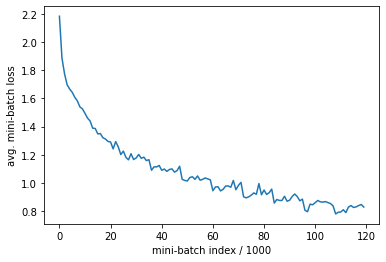

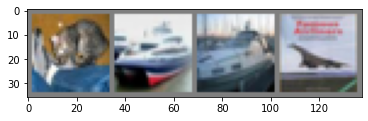

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane
Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 69 %
Accuracy of   car : 75 %
Accuracy of  bird : 48 %
Accuracy of   cat : 52 %
Accuracy of  deer : 65 %
Accuracy of   dog : 52 %
Accuracy of  frog : 69 %
Accuracy of horse : 69 %
Accuracy of  ship : 83 %
Accuracy of truck : 67 %
0.2
[epoch: 0, i:   999] avg mini-batch loss: 2.158
[epoch: 0, i:  1999] avg mini-batch loss: 1.897
[epoch: 0, i:  2999] avg mini-batch loss: 1.798
[epoch: 0, i:  3999] avg mini-batch loss: 1.745
[epoch: 0, i:  4999] avg mini-batch loss: 1.636
[epoch: 0, i:  5999] avg mini-batch loss: 1.615
[epoch: 0, i:  6999] avg mini-batch loss: 1.557
[epoch: 0, i:  7999] avg mini-batch loss: 1.559
[epoch: 0, i:  8999] avg mini-batch loss: 1.532
[epoch: 0, i:  9999] avg mini-batch loss: 1.496
[epoch: 0, i: 10999] avg mini-batch loss: 1.470
[epoch: 0, i: 11999] avg mini-batch loss: 1.456
[epoch: 1, i:   999] avg mini-batch loss:

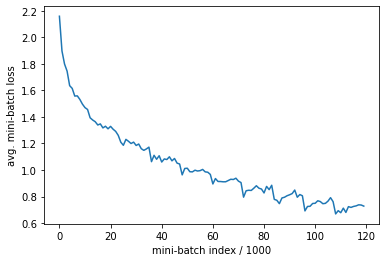

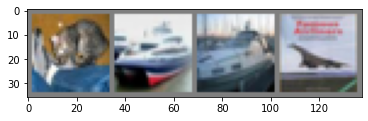

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane
Accuracy of the network on the 10000 test images: 66 %
Accuracy of plane : 74 %
Accuracy of   car : 79 %
Accuracy of  bird : 44 %
Accuracy of   cat : 39 %
Accuracy of  deer : 63 %
Accuracy of   dog : 54 %
Accuracy of  frog : 76 %
Accuracy of horse : 75 %
Accuracy of  ship : 77 %
Accuracy of truck : 77 %
0.18
[epoch: 0, i:   999] avg mini-batch loss: 2.153
[epoch: 0, i:  1999] avg mini-batch loss: 1.954
[epoch: 0, i:  2999] avg mini-batch loss: 1.829
[epoch: 0, i:  3999] avg mini-batch loss: 1.749
[epoch: 0, i:  4999] avg mini-batch loss: 1.653
[epoch: 0, i:  5999] avg mini-batch loss: 1.619
[epoch: 0, i:  6999] avg mini-batch loss: 1.568
[epoch: 0, i:  7999] avg mini-batch loss: 1.495
[epoch: 0, i:  8999] avg mini-batch loss: 1.498
[epoch: 0, i:  9999] avg mini-batch loss: 1.444
[epoch: 0, i: 10999] avg mini-batch loss: 1.455
[epoch: 0, i: 11999] avg mini-batch loss: 1.400
[epoch: 1, i:   999] avg mini-batch loss

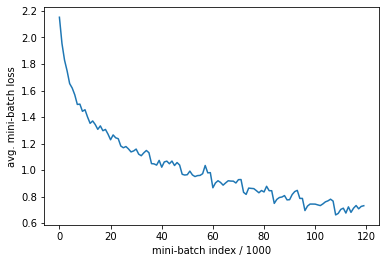

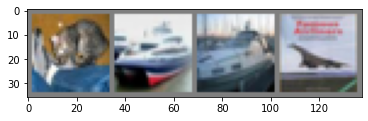

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car  ship plane
Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 75 %
Accuracy of   car : 69 %
Accuracy of  bird : 53 %
Accuracy of   cat : 53 %
Accuracy of  deer : 57 %
Accuracy of   dog : 58 %
Accuracy of  frog : 65 %
Accuracy of horse : 73 %
Accuracy of  ship : 72 %
Accuracy of truck : 76 %
0.17
[epoch: 0, i:   999] avg mini-batch loss: 2.154
[epoch: 0, i:  1999] avg mini-batch loss: 1.923
[epoch: 0, i:  2999] avg mini-batch loss: 1.788
[epoch: 0, i:  3999] avg mini-batch loss: 1.750
[epoch: 0, i:  4999] avg mini-batch loss: 1.684
[epoch: 0, i:  5999] avg mini-batch loss: 1.629
[epoch: 0, i:  6999] avg mini-batch loss: 1.626
[epoch: 0, i:  7999] avg mini-batch loss: 1.588
[epoch: 0, i:  8999] avg mini-batch loss: 1.561
[epoch: 0, i:  9999] avg mini-batch loss: 1.534
[epoch: 0, i: 10999] avg mini-batch loss: 1.485
[epoch: 0, i: 11999] avg mini-batch loss: 1.450
[epoch: 1, i:   999] avg mini-batch loss

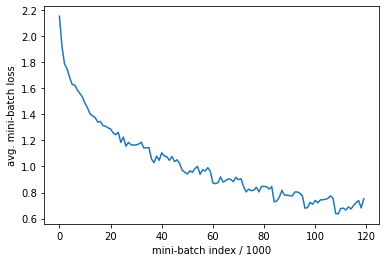

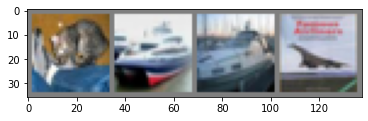

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane
Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 68 %
Accuracy of   car : 77 %
Accuracy of  bird : 49 %
Accuracy of   cat : 47 %
Accuracy of  deer : 59 %
Accuracy of   dog : 65 %
Accuracy of  frog : 67 %
Accuracy of horse : 71 %
Accuracy of  ship : 72 %
Accuracy of truck : 71 %
0.15
[epoch: 0, i:   999] avg mini-batch loss: 2.215
[epoch: 0, i:  1999] avg mini-batch loss: 1.966
[epoch: 0, i:  2999] avg mini-batch loss: 1.797
[epoch: 0, i:  3999] avg mini-batch loss: 1.721
[epoch: 0, i:  4999] avg mini-batch loss: 1.680
[epoch: 0, i:  5999] avg mini-batch loss: 1.639
[epoch: 0, i:  6999] avg mini-batch loss: 1.578
[epoch: 0, i:  7999] avg mini-batch loss: 1.543
[epoch: 0, i:  8999] avg mini-batch loss: 1.512
[epoch: 0, i:  9999] avg mini-batch loss: 1.442
[epoch: 0, i: 10999] avg mini-batch loss: 1.409
[epoch: 0, i: 11999] avg mini-batch loss: 1.423
[epoch: 1, i:   999] avg mini-batch loss

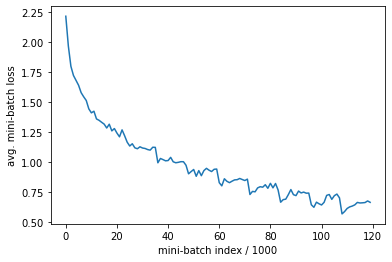

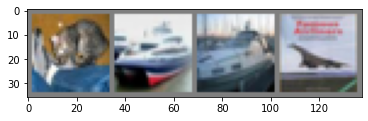

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 67 %
Accuracy of plane : 75 %
Accuracy of   car : 80 %
Accuracy of  bird : 59 %
Accuracy of   cat : 48 %
Accuracy of  deer : 52 %
Accuracy of   dog : 59 %
Accuracy of  frog : 77 %
Accuracy of horse : 63 %
Accuracy of  ship : 81 %
Accuracy of truck : 72 %
0.12
[epoch: 0, i:   999] avg mini-batch loss: 2.205
[epoch: 0, i:  1999] avg mini-batch loss: 1.978
[epoch: 0, i:  2999] avg mini-batch loss: 1.843
[epoch: 0, i:  3999] avg mini-batch loss: 1.727
[epoch: 0, i:  4999] avg mini-batch loss: 1.685
[epoch: 0, i:  5999] avg mini-batch loss: 1.603
[epoch: 0, i:  6999] avg mini-batch loss: 1.572
[epoch: 0, i:  7999] avg mini-batch loss: 1.563
[epoch: 0, i:  8999] avg mini-batch loss: 1.528
[epoch: 0, i:  9999] avg mini-batch loss: 1.518
[epoch: 0, i: 10999] avg mini-batch loss: 1.475
[epoch: 0, i: 11999] avg mini-batch loss: 1.469
[epoch: 1, i:   999] avg mini-batch loss

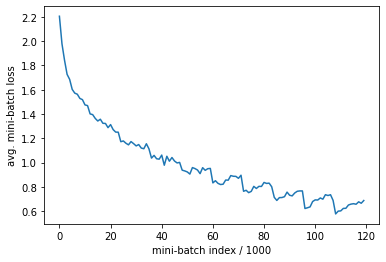

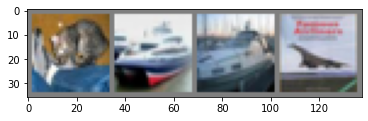

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane
Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 69 %
Accuracy of   car : 83 %
Accuracy of  bird : 44 %
Accuracy of   cat : 42 %
Accuracy of  deer : 61 %
Accuracy of   dog : 48 %
Accuracy of  frog : 80 %
Accuracy of horse : 77 %
Accuracy of  ship : 74 %
Accuracy of truck : 71 %


In [11]:
p_list = [0.3, 0.2, 0.18, 0.17, 0.15, 0.12]

for ns in p_list:
    print(ns)
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()

            #block one
            self.c_1 = nn.Conv2d(3, 10, 3, stride=1, padding=1)
            self.r_1 = nn.LeakyReLU(negative_slope=ns)
            self.avg_1 = AvgPool2d(2)

            #block two
            self.c_2 = nn.Conv2d(10, 20, 3, stride=1, padding=1)
            self.r_2 = nn.LeakyReLU(negative_slope=ns)
            self.avg_2 = AvgPool2d(2)

            self.l_1 = nn.Linear(1280, 100)
            self.r_3 = nn.LeakyReLU(negative_slope=ns)
            self.l_2 = nn.Linear(100, 10)

        def forward(self, x):
            ###### Fill the blank here ######
            x = self.c_1(x)
            x = self.r_1(x)
            x = self.avg_1(x)
            x = self.c_2(x)
            x = self.r_2(x)
            x = self.avg_2(x)
            x = x.view(x.size(0), -1)
            x = self.l_1(x)
            x = self.r_3(x)
            x = self.l_2(x)

            return x


    net = Net()     # Create the network instance.
    net.to(device)  # Move the network parameters to the specified device.

    # We use cross-entropy as loss function.
    loss_func = nn.CrossEntropyLoss()

    # SGD
    opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 


    # Training procedure
    st = time.time()
    avg_losses = []   # Avg. losses.
    epochs = 10       # Total epochs.
    print_freq = 1000  # Print frequency.

    for epoch in range(epochs):  # Loop over the dataset multiple times.
        running_loss = 0.0       # Initialize running loss.
        for i, data in enumerate(trainloader, 0):
            # Get the inputs.
            inputs, labels = data
    #         print(inputs)
    #         print(labels)
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
            opt.zero_grad()

            # Forward step.
            outputs = net(inputs)
            loss = loss_func(outputs, labels)

            # Backward step.
            loss.backward()

            # Optimization step (update the parameters).
            opt.step()

            # Print statistics.
            running_loss += loss.item()
            if i % print_freq == print_freq - 1: # Print every several mini-batches.
                avg_loss = running_loss / print_freq
                print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                    epoch, i, avg_loss))
                avg_losses.append(avg_loss)
                running_loss = 0.0

    print('Finished Training.')
    et = time.time()
    print((et-st)/60)

    plt.plot(avg_losses)
    plt.xlabel('mini-batch index / {}'.format(print_freq))
    plt.ylabel('avg. mini-batch loss')
    plt.show()


    # Check several images.
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))


    # Get test accuracy.
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


    # Get test accuracy for each class.
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

LeakyReLU(negative_slope=0.1)
[epoch: 0, i:  4999] avg mini-batch loss: 1.882
[epoch: 0, i:  9999] avg mini-batch loss: 1.558
[epoch: 1, i:  4999] avg mini-batch loss: 1.375
[epoch: 1, i:  9999] avg mini-batch loss: 1.283
[epoch: 2, i:  4999] avg mini-batch loss: 1.156
[epoch: 2, i:  9999] avg mini-batch loss: 1.130
[epoch: 3, i:  4999] avg mini-batch loss: 1.041
[epoch: 3, i:  9999] avg mini-batch loss: 1.023
[epoch: 4, i:  4999] avg mini-batch loss: 0.929
[epoch: 4, i:  9999] avg mini-batch loss: 0.943
[epoch: 5, i:  4999] avg mini-batch loss: 0.844
[epoch: 5, i:  9999] avg mini-batch loss: 0.883
[epoch: 6, i:  4999] avg mini-batch loss: 0.777
[epoch: 6, i:  9999] avg mini-batch loss: 0.824
[epoch: 7, i:  4999] avg mini-batch loss: 0.719
[epoch: 7, i:  9999] avg mini-batch loss: 0.762
[epoch: 8, i:  4999] avg mini-batch loss: 0.673
[epoch: 8, i:  9999] avg mini-batch loss: 0.707
[epoch: 9, i:  4999] avg mini-batch loss: 0.621
[epoch: 9, i:  9999] avg mini-batch loss: 0.674
Finished T

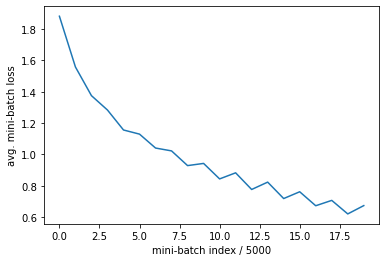

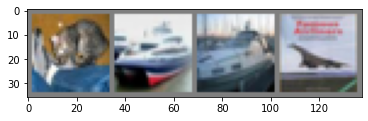

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane
Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 74 %
Accuracy of   car : 79 %
Accuracy of  bird : 45 %
Accuracy of   cat : 47 %
Accuracy of  deer : 61 %
Accuracy of   dog : 55 %
Accuracy of  frog : 74 %
Accuracy of horse : 68 %
Accuracy of  ship : 73 %
Accuracy of truck : 71 %


In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #block one
        self.c_1 = nn.Conv2d(3, 10, 3, stride=1, padding=1)
        self.r_1 = nn.LeakyReLU(negative_slope=0.1)
        self.avg_1 = AvgPool2d(2)

        #block two
        self.c_2 = nn.Conv2d(10, 20, 3, stride=1, padding=1)
        self.r_2 = nn.LeakyReLU(negative_slope=0.1)
        self.avg_2 = AvgPool2d(2)

        self.l_1 = nn.Linear(1280, 100)
        self.r_3 = nn.LeakyReLU(negative_slope=0.1)
        self.l_2 = nn.Linear(100, 10)

    def forward(self, x):
        ###### Fill the blank here ######
        x = self.c_1(x)
        x = self.r_1(x)
        x = self.avg_1(x)
        x = self.c_2(x)
        x = self.r_2(x)
        x = self.avg_2(x)
        x = x.view(x.size(0), -1)
        x = self.l_1(x)
        x = self.r_3(x)
        x = self.l_2(x)

        return x


net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()

# SGD
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 


# Training procedure
st = time.time()
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 5000  # Print frequency.

print('LeakyReLU(negative_slope=0.1)')
for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
#         print(inputs)
#         print(labels)
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')
et = time.time()
print((et-st)/60)

plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()


# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))